In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [ ]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2023-02-21 12:05:31--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  66.3MB/s    in 2.9s    

2023-02-21 12:05:34 (66.3 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [ ]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
!ls

ml-20m	ml-20m.zip  sample_data


In [ ]:
df = pd.read_csv("ml-20m/ratings.csv")

In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes

In [ ]:
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes

In [ ]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df["new_user_id"].values
movie_ids = df["new_movie_id"].values
ratings = df["rating"].values - 2.5 

In [ ]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [ ]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_embed = nn.Embedding(self.N, self.D)
    self.m_embed = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0, 1) leads to poor results
    self.u_embed.weight.data = nn.Parameter(torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_embed.weight.data = nn.Parameter(torch.Tensor(np.random.randn(self.N, self.D) * 0.01))

  def forward(self, user, movie):
    user = self.u_embed(user) # output is num_samples x D
    movie = self.m_embed(movie) # output is num_samples x D

    # merge
    out = torch.cat((user, movie), 1) # output is num_samples x 2D

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_embed): Embedding(138493, 10)
  (m_embed): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [ ]:
def batch_gd(model, criterion, optimizer, train_data, test_data, epochs, batch_size=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data
  
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / batch_size))

  for i in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(train_users, train_movies, train_ratings)

    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j * batch_size: (j + 1) * batch_size]
      movies = train_movies[j * batch_size: (j + 1) * batch_size]
      targets = train_ratings[j * batch_size: (j + 1) * batch_size]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      # Backward and Optimize
      loss.backward()
      optimizer.step()
      
      train_loss.append(loss.item())

    train_losses[i] = np.mean(train_loss)

    model.eval()
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / batch_size))):
      # get the batch
      users = test_users[j * batch_size: (j + 1) * batch_size]
      movies = test_movies[j * batch_size: (j + 1) * batch_size]
      targets = test_ratings[j * batch_size: (j + 1) * batch_size]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
      # reshape the target
      targets = targets.view(-1, 1).float()
      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    
    test_losses[i] = np.mean(test_loss)

    dt = datetime.now() - t0
    print(f"Epoch: {i+1} / {epochs}, Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}, Duration: {dt}")
  
  return train_losses, test_losses

In [ ]:
# shuffle the data in corresponding order 
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [36]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd(model, criterion, optimizer, (train_users, train_movies, train_ratings), (test_users, test_movies, test_ratings), 10)

Epoch: 1 / 10, Train Loss: 0.7356, Test Loss: 0.6917, Duration: 0:14:40.544992
Epoch: 2 / 10, Train Loss: 0.6699, Test Loss: 0.6661, Duration: 0:14:50.855571
Epoch: 3 / 10, Train Loss: 0.6372, Test Loss: 0.6537, Duration: 0:15:00.682171
Epoch: 4 / 10, Train Loss: 0.6142, Test Loss: 0.6370, Duration: 0:14:40.415849
Epoch: 5 / 10, Train Loss: 0.5970, Test Loss: 0.6324, Duration: 0:14:46.667950
Epoch: 6 / 10, Train Loss: 0.5845, Test Loss: 0.6307, Duration: 0:14:40.388906
Epoch: 7 / 10, Train Loss: 0.5749, Test Loss: 0.6266, Duration: 0:14:44.068804
Epoch: 8 / 10, Train Loss: 0.5678, Test Loss: 0.6263, Duration: 0:14:36.526871
Epoch: 9 / 10, Train Loss: 0.5622, Test Loss: 0.6263, Duration: 0:14:40.239509
Epoch: 10 / 10, Train Loss: 0.5573, Test Loss: 0.6257, Duration: 0:14:31.185777


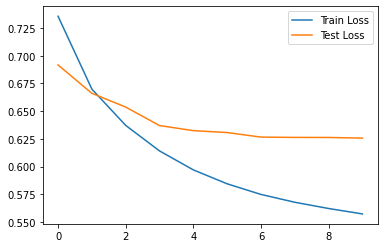

In [37]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [38]:
# Suppose I want to find recommendations for user_id = 1
# First find all the movie ids for movies they haven't yet watched
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values

In [39]:
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [40]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [41]:
potential_movie_ids.shape

(26683,)

In [42]:
len(set(potential_movie_ids))

26683

In [43]:
# Repeat the user id this many times
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [44]:
# Convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get predictions
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [45]:
# Convert predictions to Numpy
predictions_np = predictions.cpu().numpy().flatten()

In [46]:
# Get sort index for predictions
sort_idx = np.argsort(-predictions_np)

In [47]:
predictions_np

array([1.561099 , 1.1314094, 2.0379078, ..., 1.5305789, 1.4829282,
       1.4799558], dtype=float32)

In [48]:
sort_idx

array([  848,   270,    34, ...,  3646, 13520,  8795])

In [49]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print(f"Movie: {movie}, Score: {score}")

Movie: 10109, Score: 2.633188009262085
Movie: 2486, Score: 2.6153388023376465
Movie: 1212, Score: 2.6105380058288574
Movie: 1017, Score: 2.610189914703369
Movie: 7206, Score: 2.6038432121276855
Movie: 23332, Score: 2.596259117126465
Movie: 12002, Score: 2.5904133319854736
Movie: 1173, Score: 2.580634117126465
Movie: 7982, Score: 2.5662753582000732
Movie: 22016, Score: 2.561558723449707
